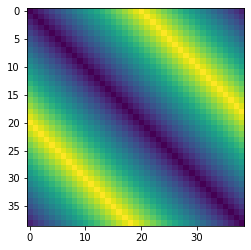

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

n= 40
x = np.indices((n,n))
y_c = np.concatenate(x[0])
x_c = np.concatenate(x[1])

def comp_dist(a, b):
    na = int(np.sqrt(len(a)))
    nb = int(np.sqrt(len(b)))
    #print((a))
    a_ = np.tile(a, (nb**2,1))
    b_ = np.tile(b, (na**2,1))
    
    dist1 = np.abs(a_-b_.T)
    dist2 = n - dist1
    return np.minimum(dist1, dist2)

xdist = comp_dist(x_c,x_c)
ydist = comp_dist(y_c,y_c)
dist_f = np.sqrt(xdist**2+ydist**2)
plt.imshow(dist_f[0:39,0:39])

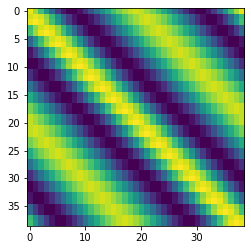

In [2]:
directions = [[1,0],[0,1],[-1,0],[0,-1]]#  E N W S
z = 2 * (y_c % 2) + x_c % 2

g = np.take(directions, z, axis=0)# g is an array with the vector of directional preference for each neuron
#print(g.shape)
#print(g[:, 0].shape)
x_s = x_c - g[:, 0]# subtract to each neuron position the vector of directional preference.
y_s = y_c - g[:, 1]

xdist = comp_dist(x_c,x_s)
ydist = comp_dist(y_c,y_s)
dist_f = np.sqrt(xdist**2+ydist**2)
#plt.imshow(dist_f)

def rec(d):
    llambda = 15
    beta = 3 /(llambda**2)
    gamma = 1.05*beta
    w = np.exp(-gamma*d**2)-np.exp(-beta*d**2)
    return w

w_rec = rec(dist_f)
plt.imshow(w_rec[0:39, 0 :39])

def dynamics(b, s0, w, tau, dt):
    """Solve the grid cell spiking equation with implicit euler for one time step of size dt"""
    
    f = np.maximum(0, np.tensordot(s0, w, axes=1) + b)
    s = (s0 + f * dt / tau) / (1 + dt / tau)
    return s


def calculate_B(v):
    g_m = 0.7
    alpha = 0.10315
    tau = 1e-1
    dt = 1e-2
    #print(g)
    #print(v)
    B = 1 + g_m * alpha * np.tensordot(g, v, axes=1)
    return B

In [3]:
# initialization
nr_steps =1000
s = np.random.rand(n**2)*10**(-2)
tau = 1e-1
dt = 1e-2
for i in range(nr_steps):
    v = np.random.rand(2)*0.2
    B = calculate_B(v)
    s = dynamics(B, s, w_rec, tau, dt)
s0 = s
# s_resh = np.reshape(s0, (40,40))
# plt.imshow(s_resh)

In [4]:
# simulation
s = s0
vv = [0, 0]
V= np.array(vv)*0.2
nr_steps_shift =500
fig = plt.figure()
for i in range(nr_steps_shift):
    B = calculate_B(V)
    s = dynamics(B, s, w_rec, tau, dt)
t0 = s
#plt.imshow(np.reshape(s, (40,40)))

#add some time to stabilize the grid pattern after movement
nr_steps_time =1000
fig = plt.figure()
for i in range(nr_steps_time):
    v_time = np.random.rand(2)*0.2
    B = calculate_B(v_time)
    s = dynamics(B, s, w_rec, tau, dt)
#plt.imshow(np.reshape(s, (40,40)))
t = s


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

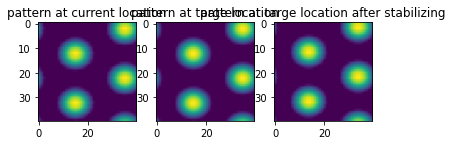

In [5]:
plt.subplot(131)
plt.title("pattern at current location")
plt.imshow(np.reshape(s0, (40,40)))

plt.subplot(132)
plt.title("pattern at targe location")
plt.imshow(np.reshape(t0, (40,40)))

plt.subplot(133)
plt.title("pattern at targe location after stabilizing")
plt.imshow(np.reshape(t, (40,40)))

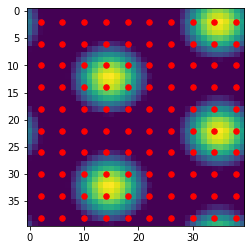

In [6]:
def in_(d):
    eta = 0.25
    #print(d.shape)
    beta = 3/ 15**2
    weight_in = eta * ( np.exp(-beta * d**2) - 1 )
    #print(weight_in.shape)
    return weight_in

def ex_(d):
    beta = 3 / 15**2
    weight_ex = np.exp(-beta*d**2)
    return weight_ex

n_pod = 10 #size 
num_dir = 16 # number of directions of  phase offset detectors
theta_pod = np.linspace(0, 2*np.pi, num_dir+1) 
theta_pod = theta_pod[0:num_dir] 
#print(theta_pod)

x_pod = (np.indices((n_pod,n_pod))+1/2)*(n/(n_pod)) # create the POD and scaling it up to the grid cell dimensions. size n and scaling chosen to cover the whole grid cell
#print(x_pod)
y_c_pod = np.concatenate(x_pod[0]) # 
x_c_pod = np.concatenate(x_pod[1]) # 

v = np.reshape(s0,(40,40))
plt.imshow(v)
plt.scatter(x=x_pod[1], y=x_pod[0], c='r', s=30)

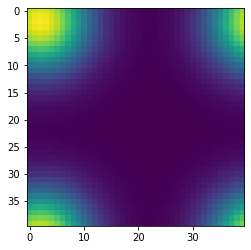

In [7]:
xd = comp_dist(x_c_pod, x_c)
yd = comp_dist(y_c_pod, y_c)
d = np.sqrt(xd**2+yd**2)
w_in = in_(d)
#print(w_in.shape)
plt.imshow(np.reshape(w_in[:,0],(40,40)))
#plt.imshow(np.reshape(w_in,(40,4000)))


(1600, 100)


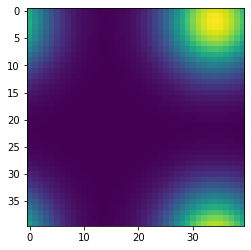

In [8]:
delta = 8 # 5 for the value 7 i don't get an response from th ephase offset detector for this example shift
w_ex = np.zeros((n**2, n_pod**2, num_dir))
for i, angle in enumerate(theta_pod):
    #print(angle)
    y_c_pod_t = np.concatenate(x[0]) + delta * np.sin(angle)
    x_c_pod_t = np.concatenate(x[1]) + delta * np.cos(angle)
    xd = comp_dist(x_c_pod, x_c_pod_t)
    yd = comp_dist(y_c_pod, y_c_pod_t)
    d = np.sqrt(xd**2+yd**2)
    #print(ex_(d).shape)
    w_ex[:, :, i] = ex_(d)
print(w_ex[:,:,0].shape)
plt.imshow(np.reshape(w_ex[:,0,0],(40,40)))

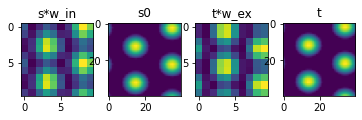

In [9]:
plt.subplot(141)
O = np.dot(s0,w_in)
plt.title('s*w_in')
plt.imshow(np.reshape(O,(10,10)))


plt.subplot(142)
plt.title('s0')
plt.imshow(np.reshape(s0, (40,40)))


plt.subplot(143)
P = np.dot(t, w_ex[:,:,13])
plt.title('t*w_ex')
plt.imshow(np.reshape(P, (10,10)))


plt.subplot(144)
plt.title('t')
plt.imshow(np.reshape(t, (40,40)))


In [10]:
p = np.empty((n_pod**2, num_dir))
for idx, angle in enumerate(theta_pod):
    p[:,idx] = np.dot(s0,w_in) + np.dot(t, w_ex[:,:,idx])


# No ReLU

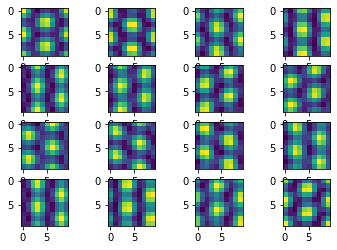

In [11]:
for a in range(num_dir):
    plt.subplot(4, 4, a+1)
    #plt.title("N_R")
    plt.imshow(np.reshape(p[:,a], (10,10)))

#     plt.subplot(4, 8, a+1)
#     plt.title("ReLU")
#     plt.imshow(np.reshape(np.maximum(0, p[:,a]), (10,10)))

# ReLU

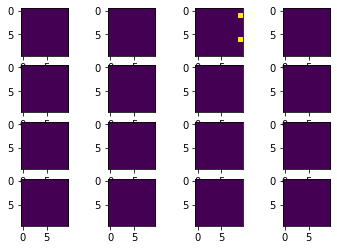

In [12]:
for a in range(num_dir):
    plt.subplot(4, 4, a+1)
    #plt.title("ReLU")
    plt.imshow(np.reshape(np.maximum(0, p[:,a]), (10,10)))

In [13]:
p_theta = np.sum(np.maximum(0, p), axis = 0)
#print(theta.shape)
xx = 0
yy = 0
for idx, angle in enumerate(theta_pod):
    #print(angle, np.cos(angle))
    #print(np.cos(angle).shape)
    xx += p_theta[idx] * np.cos(angle)
    yy += p_theta[idx] * np.sin(angle)
THETA = [xx,yy]
print(THETA)
print(np.max(np.maximum(0,p)))

[0.07398081662755883, 0.07398081662755883]
0.05231234075252189


for v=[1.5 1.5] without np.max(0, p) goal vector [0.006051055914895187, 1.9326762412674725e-12]


delta = 11

for v=[1.5 1.5] with np.max(0, p) goal vector [0.6164946920579968, -0.6344377718136491]

0.24396900932914756, 0.7546137492698817

0.7800984372971729, 0.9271149721117973

[0.7098635924826641, 0.020931417488778137]

[0.6261197646574858, -4.027705327472479]


delta = 7 

[0.5780530744680039, 0.5103465782067066]

[-0.16965297589084916, 0.4783034450434319]

[0.33507899112023903, -0.33718731844432026]

[0.6371668920456857, 0.4430629763769465]

[0.42721897768666905, -2.352590848077949]

Maximum of p is 0.85. array 0
0.029563421249431343
0.8246






In [14]:
p_array = np.empty((num_dir, 1))
for idx, angle in enumerate(theta_pod):
    #print(type(w_in),type(np.tile(s, (int(n_pod ** 2), 1))), w_in.shape, np.tile(s, (int(n_pod ** 2),1)).shape)
    p_in = np.multiply( w_in.T, np.tile(s0, (int(n_pod ** 2), 1)))
    p_ex = np.multiply(np.tile(t, (int(n_pod ** 2), 1)), w_ex[:,:,idx].T)

    p = np.maximum(0, np.sum(p_in, axis=1) + np.sum(p_ex, axis=1))
    p_m = np.sum(p)
    p_array[idx] = p_m

In [15]:
angles = theta_pod
print(p_array.shape)
x__ = np.dot(np.cos(angles), p_array)[0]
y__ = np.dot(np.sin(angles), p_array)[0]
goal_vector = np.array([x__, y__]) #* self.factor
print(goal_vector)

(16, 1)
[0.07398082 0.07398082]


Comparison between Tim's and my phase offsset detector results:
Tim:
parameters:

- goal vector -1.07566962,  1.00476571
- velocity [-0.004792142628391083, 0.0109719220917532]
            [-0.008372097118552543, 0.01992253814397267]
            [-0.01119791211022228, 0.028311165185164452]
            [-0.009735606315320246, 0.029300679175991773]
            
            
base_position = [5.5, 0.55, 0.02]
arena_size = 15
goal_location = np.array([1.5, 10])

4, 9.5    2.3 is the ratio


In [16]:
r=9.5/4
uj=-0.004792142628391083/ 0.0109719220917532
ui=-0.008372097118552543/ 0.01992253814397267
up=-0.01119791211022228/ 0.028311165185164452
uz=-0.009735606315320246/ 0.029300679175991773
print(r, 1/uj, 1/ui, 1/up, 1/uz)

2.375 -2.2895650114314146 -2.3796353365065945 -2.5282539197034715 -3.009640922916463


In [17]:
import numpy as np 

In [18]:
np.arctan(9.5/4)/2/np.pi*360

67.16634582208245

In [19]:
rho= 0.27